In [382]:
import numpy as np
import pandas as pd
from numpy import pi as pi
from scipy import interpolate
from scipy.misc import derivative
import matplotlib.pyplot as plt

In [383]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

# threshold quadratic transfer function
def f(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

# Independent noise

In [384]:
def two_ring_model(t0, T, dt, phi, N, tau_E, tau_I, tau_n, c_ne, c_ni, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c, a, b):
    # firing rate vectors for ring 1 and ring 2
    r1 = np.zeros((2*N,1))
    r2 = np.zeros((2*N,1))
    r_E1 = np.zeros((N,1))
    r_I1 = np.zeros((N,1))
    r_E2 = np.zeros((N,1))
    r_I2 = np.zeros((N,1))

    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((4*N, 1))
    R_n = np.zeros((4*N, 1))

    xs = np.linspace(0, N-1, N)

    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # Connectivity matrix 
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)

    W_E1E1 = W_E2E2 = J_EE*G_ori
    W_E1I1 = W_E2I2 = J_EI*G_ori
    W_I1E1 = W_I2E2 = J_IE*G_ori
    W_I1I1 = W_I2I2 = J_II*G_ori

    W_E1E2 = b*W_E2E2 # b scales ring2 output connectivity strength wrt within ring2 connectivity strength
    W_E1I2 = b*W_E2I2
    W_I1E2 = b*W_I2E2
    W_I1I2 = b*W_I2I2

    W_E2E1 = a*W_E1E1 # a scales ring1 output connectivity strength wrt within ring1 connectivity strength
    W_E2I1 = a*W_E1I1
    W_I2E1 = a*W_I1E1
    W_I2I1 = a*W_I1I1

    W = np.block([
        [W_E1E1, W_E1I1, W_E1E2, W_E1I2], 
        [W_I1E1, W_I1I1, W_I1E2, W_I1I2], 
        [W_E2E1, W_E2I1, W_E2E2, W_E2I2], 
        [W_I2E1, W_I2I1, W_I2E2, W_I2I2]
    ])
    
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])


    h = np.block([
        [h],
        [h],
        [h],
        [h]
    ])

    r_ss = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    r_n = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    # initial inputs 
    Id = c*h + (sgn*W)@r_ss
    In = c*h + (sgn*W)@r_n
    
    
    # smoothed noise process 
    eta = np.zeros((4*N, 1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    for m in range(M):
    # deterministic sim
        r_ss += dt*(1/tau)*(-r_ss + f(k, n, Id))
        Id = c*h + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(4*N,1)
        eta += (1/tau_n) * (-eta * dt + np.sqrt(2*tau_n*dt)*x)
        r_n += dt*(1/tau)*(-r_n + f(k, n, In + c_n*eta))
        In = c*h + (sgn*W)@r_n # note: sgn matrix incorporates minus signs for I
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, xs, ts, c, h

In [385]:
def calculate_cov(f, N, r_ss, W, c_ne, c_ni, tau_n):
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])
    
    xs = np.arange(-20000,20000)
    df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(f(0.04, 2, xs), prepend=0))
    L = np.diagflat(df(c*h + (sgn*W)@r_ss))
    
    LW = L@W
    Eye = np.eye(4*N)
    
    M = -Eye + LW
    Minv = np.linalg.inv(M)
    
    c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))
    
    D = c_n@L
    D = np.sqrt(2*tau_n)*D

    Sigma = Minv@D@((Minv@D).T)
    
    return Sigma    

In [397]:
r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                             T=500, 
                                             dt=0.1, 
                                             phi=45, 
                                             N=180, 
                                             tau_E=20, 
                                             tau_I=10, 
                                             tau_n = 1, 
                                             c_ne=1, 
                                             c_ni=1, 
                                             J_EE=0.044, 
                                             J_II=0.018, 
                                             J_EI=0.023, 
                                             J_IE=0.042, 
                                             sigma_ori=32, 
                                             sigma_FF=30, 
                                             k=0.04, 
                                             n=2.0, 
                                             c=40,
                                             
                                             a=.04, 
                                             b=.05)

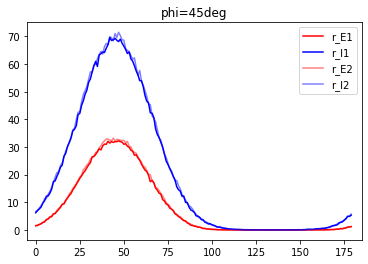

In [398]:
N = 180

plt.plot(r_n[:N], label='r_E1', color='r', alpha=1)
plt.plot(r_n[N:2*N], label='r_I1', color='b', alpha=1)
plt.plot(r_n[2*N:3*N], label='r_E2', color='r', alpha=.5)
plt.plot(r_n[3*N:], label='r_I2', color='b', alpha=.5)
plt.title('phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

## Theory

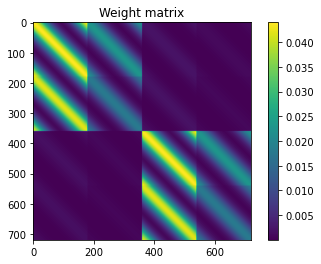

In [399]:
plt.imshow(W)
plt.colorbar()
plt.title('Weight matrix')
plt.show()

In [400]:
Sigma = calculate_cov(f=f, N=180, r_ss=r_ss, W=W, c_ne=1, c_ni=1, tau_n=1)

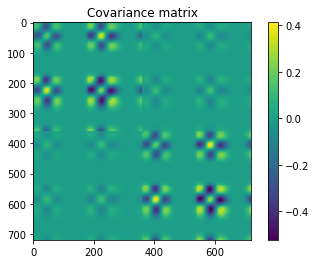

In [401]:
plt.imshow(Sigma - np.diagflat(np.diag(Sigma)))
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

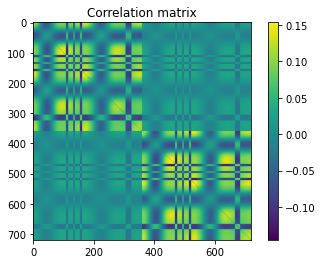

In [402]:
D = np.sqrt(np.diagflat(np.diag(Sigma)))
Dinv = np.linalg.inv(D)
C = Dinv @ Sigma @ Dinv

plt.imshow(C-np.diagflat(np.diag(C)))
plt.title('Correlation matrix')
plt.colorbar()
plt.show()

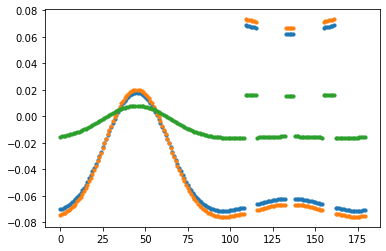

In [403]:
C1_E = C[:N, :N]
C2_E = C[2*N:3*N, 2*N:3*N]
C12_E = C[:N, 2*N:3*N]

y1 = np.delete(C1_E[45,:], [45])
y2 = np.delete(C2_E[45,:], [45])
y12 = np.delete(C12_E[45,:], [45])

xs = np.arange(180)
xs = np.delete(xs, [45])
plt.scatter(xs, y1, s=10)
plt.scatter(xs, y2, s=10)
plt.scatter(xs, y12, s=10)

plt.show()

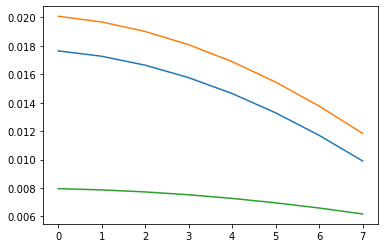

In [404]:
plt.plot(C1_E[45,46:54])
plt.plot(C2_E[45,46:54])
plt.plot(C12_E[45,46:54])
plt.show()